In [1]:
import math
import warnings
warnings.filterwarnings('ignore')
import datetime
from datetime import timedelta

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold

from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import silhouette_score, silhouette_samples, mean_squared_error, mean_absolute_error, r2_score

In [2]:
# path = '/content/content/MyDrive/[ML DL] data/[Dacon]전력사용량 예측 AI 경진대회/'
path = './data/'

train = pd.read_csv(path + 'train.csv', encoding='cp949')
train['date_time'] = pd.to_datetime(train['date_time'])
test = pd.read_csv(path + 'test.csv', encoding='cp949')
test['date_time'] = pd.to_datetime(test['date_time'])


# test = test.interpolate()
# test = test.interpolate(method='polynomial', order=2)
test = test.interpolate()

In [3]:
train_col_name = ['num', 'date_time', 'y', 'temp', 'wind', 'humidity', 'rain', 'sun', 'cold_system', 'sun_system']
test_col_name = ['num', 'date_time', 'temp', 'wind', 'humidity', 'rain', 'sun', 'cold_system', 'sun_system']

train = pd.DataFrame(train.values, columns=train_col_name)
test = pd.DataFrame(test.values, columns=test_col_name)

## Preprocessing

In [4]:
train[['num', 'cold_system','sun_system']]
ice={}
hot={}
count=0
for i in range(0, len(train), len(train)//60):
    count +=1
    ice[count]=train.loc[i,'cold_system']
    hot[count]=train.loc[i,'sun_system']

for i in range(len(test)):
    test.loc[i, 'cold_system']=ice[test['num'][i]]
    test.loc[i, 'sun_system']=hot[test['num'][i]]

In [5]:
def get_pow(series):
    return math.pow(series, 0.15)

def holiday(x):
    if x.weekday() == 5 or x.weekday() == 6:
        return 1
    elif str(x.date()) == '2020-08-17':
        return 1
    else: 
        return 0

def preprocessing(df):
    df['month'] = df.date_time.apply(lambda x: x.month)
    df['weekday'] = df.date_time.apply(lambda x: x.weekday())
    df['hour'] = df.date_time.apply(lambda x: int(str(x.time())[:2]))
    df['holiday'] = df['date_time'].apply(lambda x: holiday(x))
    df.loc[df['wind'] <= 0, 'wind'] = 0
    df.loc[df['rain'] <= 0, 'rain'] = 0
    df.loc[df['sun'] <= 0, 'sun'] = 0
    df['perceived_temperature'] = 13.12 + 0.6215*df['temp'] - 11.37*df['wind'].apply(get_pow) + 0.3965*df['wind'].apply(get_pow)*df['temp']
    df['discomfort_index'] = 1.8*df['temp'] - 0.55*(1-df['humidity']/100)*(1.8*df['temp']-26) + 32
    # df['discomfort_index'] = pd.cut(df['discomfort_index'], bins = [0, 68, 75, 80, 200], labels = [1,2,3,4])
    df['monday'] = df['weekday'].apply(lambda x: 1 if x == 0 else 0)
    df.loc[:, 'rain'] = df.loc[:, 'rain'].apply(lambda x: 0 if x == 0 else 1)
    return df

In [6]:
# # ref_day

# def remove_date(x):
#     if str(x)[:10] == '2020-06-01': return 0
#     elif str(x)[:10] == '2020-06-02': return 0
#     elif str(x)[:10] == '2020-06-03': return 0
#     elif str(x)[:10] == '2020-06-04': return 0
#     elif str(x)[:10] == '2020-06-05': return 0
#     elif str(x)[:10] == '2020-06-06': return 0
#     elif str(x)[:10] == '2020-06-07': return 0
#     else: return 1

# train['remove_day'] = train['date_time'].apply(lambda x: remove_date(x))
# concat_df = pd.concat([train, test], axis=0).sort_values(by=['num', 'date_time']).reset_index(drop=True)

# df = concat_df[concat_df['remove_day'] != 0].reset_index(drop=True)
# df = df.drop('remove_day', axis=1)

# concat_df['date_time'] = concat_df['date_time'].apply(lambda x: x + timedelta(days=7))
# ref_df = concat_df.iloc[:, :3].rename({'num':'num', 'date_time':'date_time', 'y':'ref_day'}, axis=1)

# df = df.merge(ref_df, how='left', on=['num', 'date_time'])

# train = df[df.iloc[:, 2].notnull()].reset_index(drop=True)
# test = df[df.iloc[:, 2].isnull()].reset_index(drop=True).drop('y', axis=1)

In [7]:
type_columns = ['temp', 'wind', 'humidity', 'rain', 'sun', 'y']

for i in type_columns:
    if i == 'y':
        train[i] = train[i].astype('float64')
    else:
        train[i] = train[i].astype('float64')
        test[i] = test[i].astype('float64')

In [8]:
train = preprocessing(train)
test = preprocessing(test)

In [9]:
idx_31 = train[(train['num'] == 31) & (train['date_time'] == '2020-06-11 17:00:00')].index
idx_33 = train[(train['num'] == 33) & (train['date_time'] == '2020-06-11 17:00:00')].index
idx_36 = train[(train['num'] == 36) & ((train['date_time'] == '2020-08-19 05:00:00') |
                                        (train['date_time'] == '2020-08-19 06:00:00') |
                                        (train['date_time'] == '2020-08-19 07:00:00') |
                                        (train['date_time'] == '2020-08-19 08:00:00') |
                                        (train['date_time'] == '2020-08-19 09:00:00'))].index
idx_45 = train[(train['num'] == 45) & (train['date_time'] == '2020-07-05 01:00:00')].index

In [10]:
train = train.drop(idx_31, axis=0)
train = train.drop(idx_33, axis=0)
train = train.drop(idx_36, axis=0)
train = train.drop(idx_45, axis=0)

In [11]:
# kmeans = KMeans(n_clusters=4, init='k-means++', random_state=37)
# kmeans.fit(train[['temp']])

# train_cluster = kmeans.predict(train[['temp']])
# test_cluster = kmeans.predict(test[['temp']])
# train['temp_cluster'] = train_cluster
# test['temp_cluster'] = test_cluster

## Clustering

In [12]:
# min_max_scaling
for i in range(1, 61):
    mean_ = train.loc[train.num == i].y.mean()
    std_ = train.loc[train.num == i].y.std()
    train.loc[train.num == i, 'scale_y'] = ((train.loc[train.num == i, 'y']) - mean_) / std_

In [13]:
# 요일에 따른 평균 값 산출
weekday_mean = (
    train.groupby(['num', 'weekday'])['scale_y'].mean()
    .reset_index()
    .pivot('num', 'weekday', 'scale_y')
    .reset_index()
)

In [14]:
# 시간에 따른 평균 값 산출
hour_mean = (
    train.groupby(['num', 'hour'])['scale_y'].mean()
    .reset_index()
    .pivot('num', 'hour', 'scale_y')
    .reset_index()
    .drop('num', axis=1)
)

In [15]:
# 요일별, 시간별 평균 전력 사용량 테이블 구축
cl_df = pd.concat([weekday_mean, hour_mean], axis=1)

In [16]:
columns = cl_df.columns[1:].tolist()

kmeans = KMeans(n_clusters=4, init='k-means++', random_state=37)
kmeans.fit(cl_df[columns])

train_cluster = kmeans.predict(cl_df[columns])

cl_df['assignment'] = train_cluster

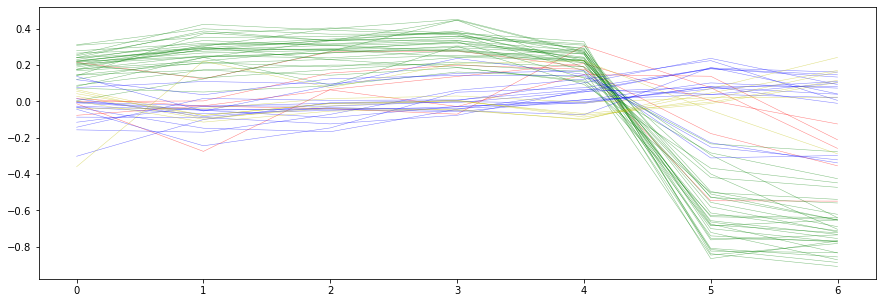

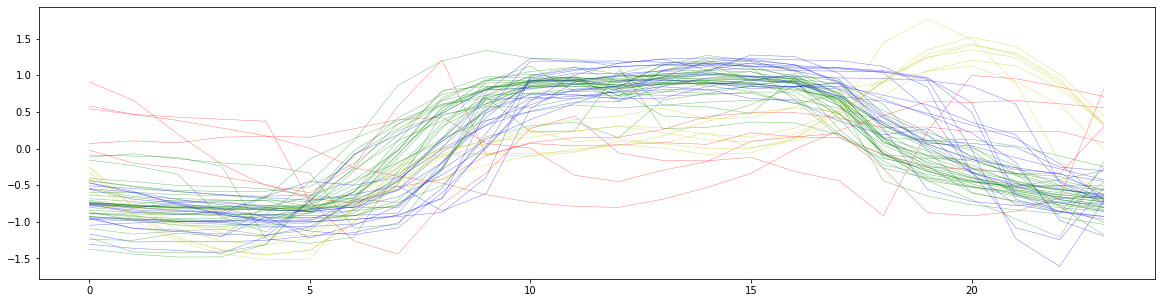

In [17]:
colors = ['r', 'g', 'b', 'y', 'k', 'orange']

fig = plt.figure(figsize = (15,5))
for idx, ass in enumerate(cl_df.assignment.unique()):
    for i in cl_df[cl_df['assignment'] == ass].iloc[:, 1:8].values:
        plt.plot(i, alpha = 0.5, linewidth = 0.5, c=colors[idx], label=ass)
    
fig = plt.figure(figsize = (20,5))
for idx, ass in enumerate(cl_df.assignment.unique()):
    for i in cl_df[cl_df['assignment'] == ass].iloc[:, 8:32].values:
        plt.plot(i, alpha = 0.5, linewidth = 0.5, c=colors[idx], label=ass)

In [18]:
clusters = cl_df[['num', 'assignment']]

train = train.merge(clusters, how='left', on='num')
test = test.merge(clusters, how='left', on='num')

train = train.drop('scale_y', axis=1)

In [19]:
# #군집별 가중치 부여

# lst = []
# p_lst = []

# for i in range(5):
#     m = train[(train['num'] == 37) & (train['cluster'] == i)]['y'].mean()
#     lst.append(m)

# for i in range(5):
#     p = train[(train['num'] == 37) & (train['cluster'] == i)]['y'].mean() / np.sum(lst)
#     p_lst.append(p)

# train['cluster_weight'] = train.cluster.apply(lambda x: p_lst[x])
# test['cluster_weight'] = test.cluster.apply(lambda x: p_lst[x])

## Train Test Split

In [20]:
def feature_label_split(df):
    y = df['y']
    X = df.drop(['date_time', 'y'], axis = 1).reset_index(drop=True)
    y = y.astype('float32')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=X['num'], random_state=37)
    
    return X_train, X_test, y_train, y_test

In [21]:
X_train, X_test, y_train, y_test = feature_label_split(train)

In [22]:
test = test.drop('date_time', axis=1)

In [23]:
def data_scaler(train_data, test_data, test):
    scaler = StandardScaler()
    scaler.fit(train_data.drop('num', axis=1))
    X = scaler.transform(train_data.drop('num', axis=1))
    X_test = scaler.transform(test_data.drop('num', axis=1))
    scaled_test = scaler.transform(test.drop('num', axis=1))
    
    col_name = ['temp', 'wind', 'humidity', 'rain', 'sun', 'cold_system', 'sun_system', 'month', 'weekday', 'hour', 'holiday',
                'perceived_temperature', 'discomfort_index', 'assignment', 'monday']
    
    X = pd.DataFrame(X, columns=col_name)
    X_test = pd.DataFrame(X_test, columns=col_name)
    scaled_test = pd.DataFrame(scaled_test, columns=col_name)
    

    num_train = pd.DataFrame(train_data.num.values, columns=['num'])
    num_test = pd.DataFrame(test_data.num.values, columns=['num'])
    num_t = pd.DataFrame(test.num.values, columns=['num'])
    
    
    num_train = num_train.astype('int')
    num_test = num_test.astype('int')
    num_t = num_t.astype('int')
    
    X = pd.concat([X, num_train], axis=1)
    X_test = pd.concat([X_test, num_test], axis=1)
    test = pd.concat([scaled_test, num_t], axis=1)

    return X, X_test, test

In [24]:
X_train, X_test, test = data_scaler(X_train, X_test, test)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [25]:
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred)))*200

## Modeling

In [26]:
def evaluate(X_train, y_train, X_test, model, n_fold):
    sfk = StratifiedKFold(n_splits = n_fold, random_state=37)
    models = {}
    
    y_pred = np.zeros(len(X_test))
    fold = 1

    for tr_idx, val_idx in sfk.split(X_train, X_train['num']):
        print('======== {}fold ========'.format(fold))
        feature_train = X_train.iloc[tr_idx, :]
        label_train = y_train[tr_idx]

        feature_val = X_train.iloc[val_idx, :]
        label_val = y_train[val_idx]
        
        model.fit(feature_train, label_train)
        pred = model.predict(X_test)
        
        y_pred += pred / n_fold
        
        models[fold] = model
        
        print(f'''\nMSE: {mean_squared_error(pred, y_test):.4f}
MAE: {mean_absolute_error(pred, y_test):.4f}
RMSE: {np.sqrt(mean_squared_error(pred, y_test)):.4f}
SMAPE: {SMAPE(np.array(y_test), pred):.4f}\n''')

        fold += 1
    plt.figure(figsize=(15,5))
    plt.plot(y_test, 'k' ,label='True')
    plt.plot(y_pred, '--g' ,label='Pred')
    plt.title(f'\nSMAPE: {SMAPE(np.array(y_test), y_pred):.4f}\nR2_score: {r2_score(y_pred, y_test):.4f}\n')
    plt.legend()
    plt.show()
    
    return models

======== 1fold ========

MSE: 27718.7351
MAE: 85.8101
RMSE: 166.4894
SMAPE: 4.4350

======== 2fold ========

MSE: 28349.1958
MAE: 86.0679
RMSE: 168.3722
SMAPE: 4.4526

======== 3fold ========

MSE: 28098.0666
MAE: 85.8811
RMSE: 167.6248
SMAPE: 4.4398

======== 4fold ========

MSE: 28139.2824
MAE: 85.7262
RMSE: 167.7477
SMAPE: 4.4371

======== 5fold ========

MSE: 28185.6692
MAE: 86.0539
RMSE: 167.8859
SMAPE: 4.4421

======== 6fold ========

MSE: 28283.0717
MAE: 85.6460
RMSE: 168.1757
SMAPE: 4.4318

======== 7fold ========

MSE: 27789.8601
MAE: 85.8345
RMSE: 166.7029
SMAPE: 4.4331

======== 8fold ========

MSE: 28131.5107
MAE: 86.1067
RMSE: 167.7245
SMAPE: 4.4380

======== 9fold ========

MSE: 27571.2465
MAE: 85.4979
RMSE: 166.0459
SMAPE: 4.4303

======== 10fold ========

MSE: 27549.6223
MAE: 85.8339
RMSE: 165.9808
SMAPE: 4.4470



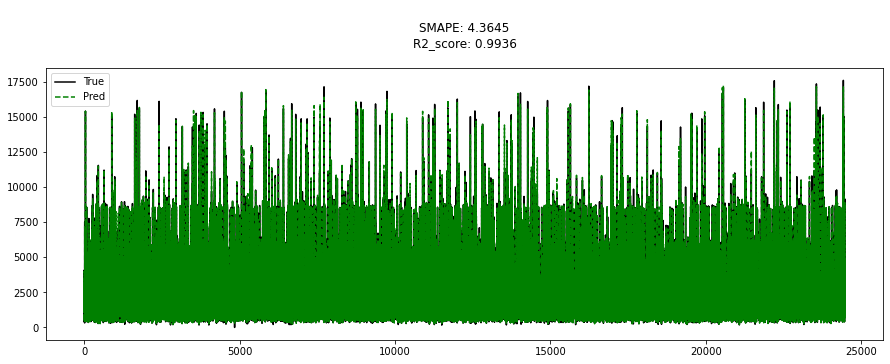

In [27]:
model = RandomForestRegressor(random_state=37)
rf_models = evaluate(X_train, y_train, X_test, model, 10)

In [34]:
model = SVR()
rf_models = evaluate(X_train, y_train, X_test, model, 10)

======== 1fold ========


======== 1fold ========
Training until validation scores don't improve for 30 rounds
[1000]	valid_0's l1: 259.546
[2000]	valid_0's l1: 203.096
[3000]	valid_0's l1: 159.016
[4000]	valid_0's l1: 147.6
[5000]	valid_0's l1: 140.695
[6000]	valid_0's l1: 134.912
[7000]	valid_0's l1: 131.456
[8000]	valid_0's l1: 129.068
[9000]	valid_0's l1: 126.539
[10000]	valid_0's l1: 124.415
[11000]	valid_0's l1: 122.783
[12000]	valid_0's l1: 121.445
[13000]	valid_0's l1: 120.789
[14000]	valid_0's l1: 119.717
[15000]	valid_0's l1: 118.747
[16000]	valid_0's l1: 118.064
Early stopping, best iteration is:
[15981]	valid_0's l1: 118.063

MSE: 50105.9750
MAE: 116.7958
RMSE: 223.8436
SMAPE: 5.8949

======== 2fold ========
Training until validation scores don't improve for 30 rounds
[1000]	valid_0's l1: 264.851
[2000]	valid_0's l1: 192.264
[3000]	valid_0's l1: 158.885
[4000]	valid_0's l1: 147.809
[5000]	valid_0's l1: 140.471
[6000]	valid_0's l1: 133.884
[7000]	valid_0's l1: 129.111
[8000]	valid_0's l1: 126.454
[90

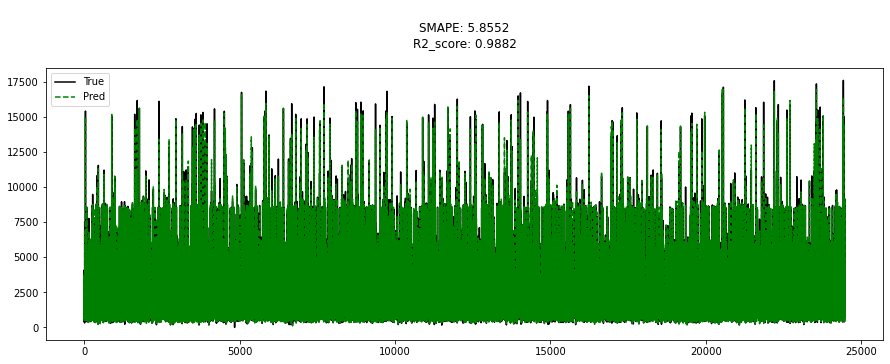

In [28]:
n_splits = 10
sfk = StratifiedKFold(n_splits = n_splits, random_state=37)
lgbm_models = {}

y_pred = np.zeros(len(X_test))
fold = 1

for tr_idx, val_idx in sfk.split(X_train, X_train['num']):
    print('======== {}fold ========'.format(fold))
    feature_train = X_train.iloc[tr_idx, :]
    label_train = y_train[tr_idx]

    feature_val = X_train.iloc[val_idx, :]
    label_val = y_train[val_idx]
    
    lgbm = LGBMRegressor(n_estimators = 20000, learning_rate= 0.01,objective = 'mae', random_state=37)
    lgbm.fit(feature_train, label_train, eval_set=[(feature_val, label_val)], eval_metric= 'mae', early_stopping_rounds=30, verbose=1000)
    pred = lgbm.predict(X_test)
    y_pred += pred / n_splits

    lgbm_models[fold] = lgbm

    print(f'''\nMSE: {mean_squared_error(pred, y_test):.4f}
MAE: {mean_absolute_error(pred, y_test):.4f}
RMSE: {np.sqrt(mean_squared_error(pred, y_test)):.4f}
SMAPE: {SMAPE(np.array(y_test), pred):.4f}\n''')

    fold += 1
    
plt.figure(figsize=(15,5))
plt.plot(y_test, 'k' ,label='True')
plt.plot(y_pred, '--g' ,label='Pred')
plt.title(f'\nSMAPE: {SMAPE(np.array(y_test), y_pred):.4f}\nR2_score: {r2_score(y_pred, y_test):.4f}\n')
plt.legend()
plt.show()

In [29]:
rf_array = np.zeros(len(test))
for i in range(1, 11):
    rf_array += rf_models[i].predict(test)/10
    

lgbm_array = np.zeros(len(test))
for i in range(1, 11):
    lgbm_array += lgbm_models[i].predict(test)/10

In [30]:
total_array = (rf_array *  0.8) + (lgbm_array * 0.2)

In [31]:
submission=pd.read_csv(path + 'sample_submission.csv')
submission['answer'] = total_array
submission.to_csv('rf_0.8_lgbm_0.2_final_interpolation_submission.csv', index=False)